## Libraries

The relevant libraries are imported. These include the numerical computation and plotting libraries.

Warnings that are occasionally generated when codes are ran are suppressed using the _"**ignore**"_ argument

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import os

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

%config InlineBackend.figure_format='png'

## Dataset

Data preprocessing enables us to ensure the data completeness and duplication and have a glimpse of the summary of the data statistics.

In [2]:
df= pd.read_excel('H2_CH4_N2_Brine IFT.xlsx').drop(['Reference', 'Title'], axis=1)
df.dropna(inplace=True)
df

,Pressure,Temperature,Salinity,xN2,xCH4,Density difference,IFT
0,1.033929,295.15,0.341880,0,20,1030.60,69.24
1,1.033929,313.15,0.341880,0,20,1024.40,67.85
2,1.033929,333.15,0.341880,0,20,1015.00,65.24
3,1.033929,295.15,0.341880,0,50,1018.40,66.26
4,1.033929,313.15,0.341880,0,50,1013.00,64.88
...,...,...,...,...,...,...,...
1657,6.892857,343.15,3.418803,5,70,1035.81,63.78
1658,10.339286,343.15,3.418803,5,70,1017.88,59.37
1659,13.785714,343.15,3.418803,5,70,1000.30,56.29
1660,17.232143,343.15,3.418803,5,70,983.14,53.12


In [3]:
X= df.drop(['IFT'],axis=1)

In [4]:
y=df['IFT'].astype(float)

In [5]:
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=0,train_size=.7)

## Hyperparameter tuning

### Bayesian Optimization

In [6]:
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Start time
start_time = time.time()

# Search space
param_space = {
    'model__learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'model__max_depth': Integer(5, 30), 
    'model__n_estimators': Integer(100, 500),
    'model__num_leaves': Integer(30, 200)
}

# Pipeline for LGBM model
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', lgb.LGBMRegressor(objective='regression', metric='mse'))
])

# Bayesian optimization
bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
)

bayes_search.fit(X_train, y_train)

best_pipeline = bayes_search.best_estimator_

# Model performance evaluation
y_pred = best_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Stop time
end_time = time.time()

# Elapsed time
elapsed_time = end_time - start_time

# Results
print(f"Hyperparameter tuning time: {elapsed_time} seconds")
print(f"Best Parameters: {bayes_search.best_params_}")
print(f"Test MSE: {mse}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 6
[LightGBM] [Info] Start training from score 64.950103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

## Model training

The optimal hyperparameter values are used in training the model.

In [7]:
lr = bayes_search.best_params_['model__learning_rate']
max_depth = bayes_search.best_params_['model__max_depth']
n_estimators = bayes_search.best_params_['model__n_estimators']

In [8]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', lgb.LGBMRegressor(learning_rate=lr,
                                max_depth=max_depth,
                                metric='mse',
                                n_estimators=n_estimators,
                                objective='regression'))])

pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 1163, number of used features: 6
[LightGBM] [Info] Start training from score 64.950103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.1058669264713291, max_depth=15,
                               metric='mse', n_estimators=449,
                               objective='regression'))])

In [9]:
import joblib

joblib.dump(pipeline, 'lgbm_pipeline.joblib')

# Load the pipeline
loaded_LightGBM_model = joblib.load('lgbm_pipeline.joblib')

## Evaluating model performance

Here, various statistical metrics such as mean absolute error, root mean square, and coefficient of determination are used to assess the performance of the constructed model.

In [10]:
# Dependent and independent variables
X_all = np.array(X)
y_all = np.array(y)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Coefficient of determination (R2)
lgbm_trainscore = r2_score(y_train, loaded_LightGBM_model.predict(X_train))
lgbm_testscore = r2_score(y_test, loaded_LightGBM_model.predict(X_test))
lgbm_allscore =r2_score(y_all, loaded_LightGBM_model.predict(X_all))

# Mean absolute error (MAE)
lgbm_mean_abs_train=mean_absolute_error(y_train,loaded_LightGBM_model.predict(X_train))
lgbm_mean_abs_test=mean_absolute_error(y_test,loaded_LightGBM_model.predict(X_test))
lgbm_mean_abs_all=mean_absolute_error(y_all,loaded_LightGBM_model.predict(X_all))


# Root mean square error (RMSE)
lgbm_root_mean_squared_train=(mean_squared_error(y_train,loaded_LightGBM_model.predict(X_train)))**0.5
lgbm_root_mean_squared_test=(mean_squared_error(y_test,loaded_LightGBM_model.predict(X_test)))**0.5
lgbm_root_mean_squared_all=(mean_squared_error(y_all,loaded_LightGBM_model.predict(X_all)))**0.5


# Average absolute percentage relative error
lgbm_aapre_train = np.mean(np.abs((y_train- loaded_LightGBM_model.predict(X_train)) / y_train))*100
lgbm_aapre_test = np.mean(np.abs((y_test- loaded_LightGBM_model.predict(X_test)) / y_test))*100
lgbm_aapre_all = np.mean(np.abs((y_all- loaded_LightGBM_model.predict(X_all)) / y_all))*100

In [12]:
lgbm_summary = {
    'R$^{2}$': [lgbm_trainscore, lgbm_testscore, lgbm_allscore],
    'MAE': [lgbm_mean_abs_train, lgbm_mean_abs_test, lgbm_mean_abs_all],
    'RMSE': [lgbm_root_mean_squared_train, lgbm_root_mean_squared_test, lgbm_root_mean_squared_all],
    'MAPE' : [lgbm_aapre_train, lgbm_aapre_test, lgbm_aapre_all]
}

In [13]:
lgbm_summary = pd.DataFrame(lgbm_summary).T

In [14]:
lgbm_summary = lgbm_summary.rename(columns = {0: 'Train', 1: 'Test', 2: 'All'})

In [15]:
lgbm_summary

,Train,Test,All
R$^{2}$,0.998957,0.988468,0.995805
MAE,0.180444,0.604332,0.307712
RMSE,0.242398,0.806387,0.486159
MAPE,0.281836,0.956993,0.484546


## Model predictions for train, test, and entire dataset

### Train data

In [16]:
df1=pd.DataFrame(X_train)

df2=pd.DataFrame(y_train)

df3=pd.DataFrame(loaded_LightGBM_model.predict(X_train), columns=['Predicted (Train)'])

df3.index=df2.index

testpred=pd.concat([df1, df2, df3],axis=1)

testpred.to_excel("LightGBM_Train.xlsx")

### Test data

In [17]:
df1=pd.DataFrame(X_test)

df2=pd.DataFrame(y_test)

df3=pd.DataFrame(loaded_LightGBM_model.predict(X_test), columns=['Predicted (Test)'])

df3.index=df2.index

testpred=pd.concat([df1, df2, df3],axis=1)

testpred.to_excel("LightGBM_Test.xlsx")

### All data

In [18]:
df1=pd.DataFrame(X)

df2=pd.DataFrame(y)

df3=pd.DataFrame(loaded_LightGBM_model.predict(X), columns=['Predicted (All)'])

df3.index=df2.index

testpred=pd.concat([df1, df2, df3],axis=1)

testpred.to_excel("LightGBM_All.xlsx")

## Permutation importance

Contrary to the correlations matrices, permutation importance considers the non-monotonic effect of the features on the output.

Density difference: 1.096482570514561
xCH4: 0.18426903287412658
Temperature: 0.14288384199316587
Pressure: 0.09233004712733982
xN2: 0.04047914979685999
Salinity: 0.017669064893516138


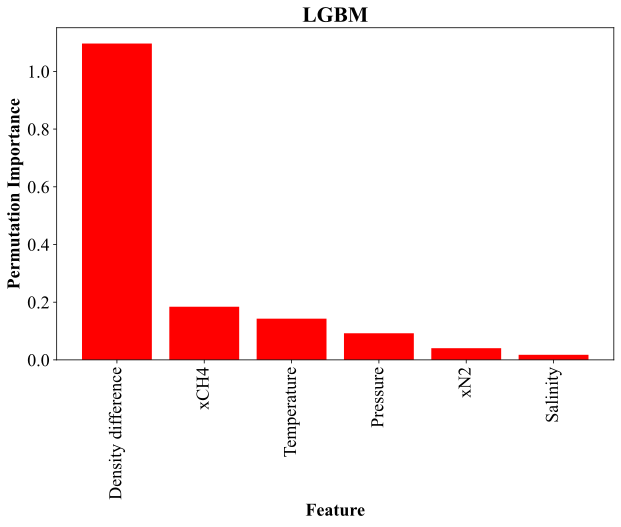

In [19]:
from sklearn.inspection import permutation_importance

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18

# Permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=0, n_jobs=-1)

# Feature importance and scores
feature_importance = result.importances_mean
feature_names = X.columns

# Sorted feature importance
sorted_idx = np.argsort(feature_importance)[::-1]

for i in sorted_idx:
    print(f'{feature_names[i]}: {feature_importance[i]}')

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], color = 'red')
plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)

plt.xlabel('Feature', fontweight = 'bold')
plt.ylabel('Permutation Importance', fontweight = 'bold')
plt.title('LGBM', fontweight = 'bold')

plt.savefig('LightGBM_Permutation Importance.png',
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Joint plot

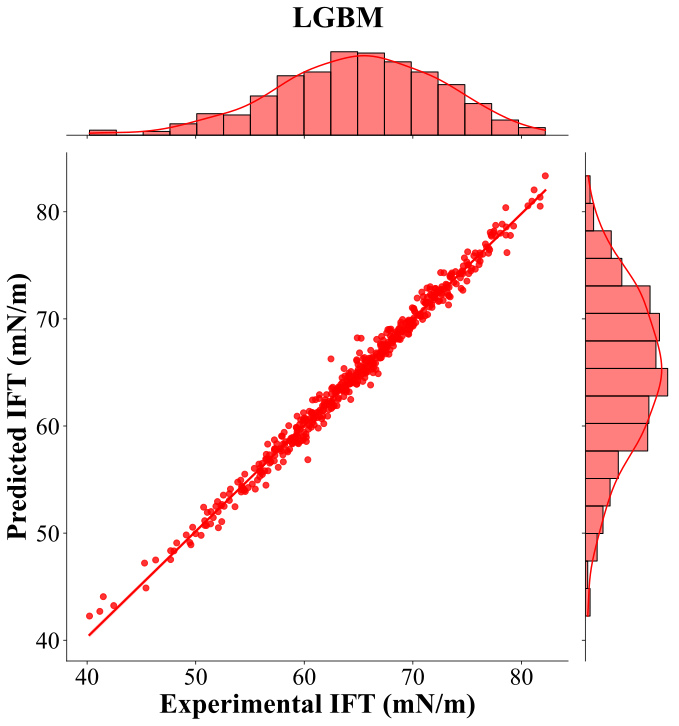

In [21]:
data = pd.read_excel('LightGBM_Test.xlsx')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

fig= sns.jointplot(x=data['IFT'],y=data['Predicted (Test)'],data=data,kind='reg', color='red', height=10)
plt.gca().set()

fig.fig.suptitle("LGBM", y=1.02, fontsize=30, fontweight='bold')

# Axis labels
fig.set_axis_labels('Experimental IFT (mN/m)', 'Predicted IFT (mN/m)', fontsize=28, fontweight = 'bold')

# Saved plot
fig.savefig("LightGBM_Joint plot of Predicted IFT Vs Experimental IFT.png",
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.show()

## Density kernel plot

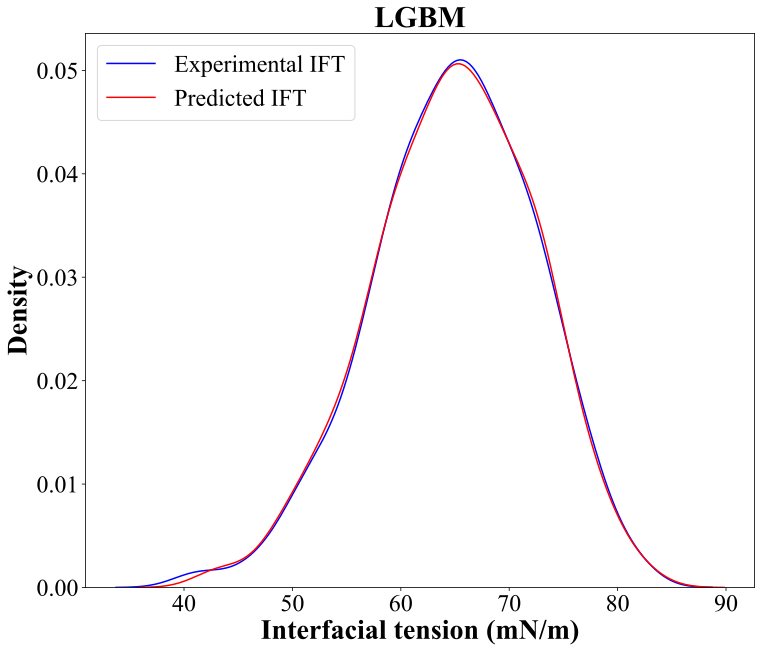

In [22]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24

fig, ax = plt.subplots(figsize=(12, 10))

# Distribution for experimental IFT values
ax1 = sns.distplot(y_test, hist=False, color="b", label="Experimental IFT")

# Distribution for predicted IFT values and previous distribution on the same axis
sns.distplot(loaded_LightGBM_model.predict(X_test), hist=False, color="r", label="Predicted IFT", ax=ax1)

# Legend
ax1.legend()

# Chart customization
ax.set_title("LGBM", fontsize=30, fontweight="bold")
ax.set_xlabel("Interfacial tension (mN/m)", fontsize=28, fontweight="bold")
ax.set_ylabel("Density", fontsize = 28, fontweight="bold")

# Saved plot
plt.savefig("LightGBM_Density_kernel_plot.png",
            format='png',
            dpi=300,
            bbox_inches='tight')

plt.show()